## Imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE

## Reading Data

In [2]:
# reading CSVs
vehicle_df = pd.read_csv('../data/localdata/Traffic_Crashes_Vehicles.csv')
people_df = pd.read_csv('../data/localdata/Traffic_Crashes_People.csv')
crash_df = pd.read_csv('../data/localdata/Traffic_Crashes_Crashes.csv')

/Users/robertdaly/Downloads/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/robertdaly/Downloads/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (20,24,25,26,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Cleaning

In [3]:
# Crashes DataFrame

crash_df.drop(columns=['WORK_ZONE_I', 'WORK_ZONE_TYPE', 'DOORING_I', 'WORKERS_PRESENT_I',
                                          'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'RD_NO', 'REPORT_TYPE', 'NOT_RIGHT_OF_WAY_I', 'CRASH_DATE_EST_I'], axis=1, inplace=True)
crash_df.dropna(subset = ['INJURIES_TOTAL', 'LATITUDE', 'MOST_SEVERE_INJURY', 
                          'STREET_DIRECTION', 'BEAT_OF_OCCURRENCE'], axis=0, inplace=True)
crash_df.columns = crash_df.columns.str.title()
crash_df.columns = crash_df.columns.str.replace('_', ' ')

In [4]:
# Vehicles DataFrame

vehicle_df = vehicle_df[['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO', 'UNIT_TYPE',
                       'VEHICLE_YEAR', 'VEHICLE_USE', 'VEHICLE_TYPE', 'MANEUVER', 'OCCUPANT_CNT',
                         'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I',
                       'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 'AREA_11_I',
                       'AREA_12_I', 'AREA_99_I', 'FIRST_CONTACT_POINT']]
vehicle_df.dropna(subset = ['VEHICLE_USE', 'FIRST_CONTACT_POINT', 'UNIT_TYPE'], axis=0, inplace=True)
vehicle_df['VEHICLE_YEAR'].fillna(value = 'Unknown', inplace=True)

vehicle_df.columns = vehicle_df.columns.str.title()
vehicle_df.columns = vehicle_df.columns.str.replace('_', ' ')

In [5]:
# People DataFrame

people_df.drop(columns=['RD_NO', 'CELL_PHONE_USE', 'PEDPEDAL_ACTION', 
                        'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'SEAT_NO', 
                        'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'BAC_RESULT', 'BAC_RESULT VALUE', 
                        'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'CITY', 'STATE', 'ZIPCODE']
               , axis=1, inplace=True)

people_df.dropna(subset = ['AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'VEHICLE_ID', 
                           'SAFETY_EQUIPMENT', 'SEX'], axis=0, inplace=True)

people_df.columns = people_df.columns.str.title()
people_df.columns = people_df.columns.str.replace('_', ' ')

## Feature Engineering Crash Score

In [6]:
# Injury Score

crash_df[['Injuries Total', 'Injuries Fatal', 'Injuries Incapacitating', 
            'Injuries Non Incapacitating', 'Injuries Reported Not Evident']][crash_df['Injuries Total']!=0][:50]

crash_df['total injured'] = crash_df['Injuries Fatal'] + crash_df['Injuries Incapacitating'] + crash_df['Injuries Non Incapacitating'] + crash_df['Injuries Reported Not Evident']

# Checking if added up columns in 'total injured' make up 'Injuries Total'
(crash_df['total injured'] == crash_df['Injuries Total']).value_counts()

# Injury Score column is a linear combination of the factors that make up Injuries Total simply multiplied by a constant depending on their severity
crash_df['Injury Score'] = crash_df['Injuries Fatal']*7 + crash_df['Injuries Incapacitating']*3 + crash_df['Injuries Non Incapacitating']*2 + crash_df['Injuries Reported Not Evident']

# Accounting Material Damage of Car and Surrounding Areas )
# Crash Score 

crash_df['Damage'].value_counts()
mapping = {'OVER $1,500': 3, '$501 - $1,500': 2, "$500 OR LESS": 1}
crash_df['Damage_ODE'] = crash_df['Damage'].map(mapping)
crash_df['Injury Score'] = crash_df['Injury Score'] + crash_df['Damage_ODE']*3
crash_df['Crash Score'] = crash_df['Injury Score']

## Injury Classification Column (Predictor)

In [7]:
def fill_injury_class_rows(row):
    if row["Injuries Fatal"] > 0 :
        return 'Fatal'
    elif row["Injuries Incapacitating"] > 0 :
        return 'Incapacitating'
    elif row['Injuries Non Incapacitating'] + row['Injuries Reported Not Evident'] > 0:
        return 'Minor'
    else:
        return 'None Injured'

crash_df['Injury Classification'] = crash_df.apply(fill_injury_class_rows, axis=1)

crash_df['Injury Classification']

0         None Injured
1         None Injured
2         None Injured
3         None Injured
4         None Injured
              ...     
753322    None Injured
753323    None Injured
753324    None Injured
753325    None Injured
753326    None Injured
Name: Injury Classification, Length: 746715, dtype: object

## Merging Vehicle and Crash DataFrames

In [8]:
vehicles_crashes_df = vehicle_df.merge(crash_df, on = 'Crash Record Id', how = 'inner')
vehicles_crashes_df.drop_duplicates(subset='Crash Record Id', inplace=True)

In [9]:
categorical = ['Weather Condition', 'Roadway Surface Cond', 'Road Defect', 'Alignment',
                       'Traffic Control Device', 'Device Condition', 'Crash Hour', 'Trafficway Type', 'Maneuver'] #potentiall vehicle defects

ohe = OneHotEncoder(drop='first')
ohe.fit(vehicles_crashes_df[categorical])

categorical_encoded = pd.DataFrame(ohe.transform(vehicles_crashes_df[categorical]).todense(),
                               columns=ohe.get_feature_names())
# for Nick's version of OneHotEncoder, since its newer, the attribute is get_feature_names_out but get_feature_name for bobby and mike's version

In [11]:
categorical_encoded.shape

(745455, 122)

In [13]:
vehicles_crashes_df.shape

(745455, 68)

## Creating Train_Test_Split

In [14]:
X = categorical_encoded
y = vehicles_crashes_df['Injury Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Creating Dummy Model

In [21]:
#Instantiate dummy model that will always predict majority class
dummy_model = DummyClassifier(strategy="most_frequent", random_state = 42)
dummy_model.fit(X_train, y_train)

#baseline score
dummy_model.score(X_train, y_train)

0.8636018107964535

In [22]:
#can also grab cross_val mean to see how it’s performing
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results.mean()

0.8636018107979073

## Testing Dummy Model

In [23]:
dummy_model.score(X_test, y_test)

0.8632461204953746

## Creating Logistic Regression Model

In [40]:
logreg = LogisticRegression(random_state=42, max_iter = 1000)
log_model = logreg.fit(X_train, y_train)

y_hat_train = log_model.predict(X_train)
y_hat_test = log_model.predict(X_test)

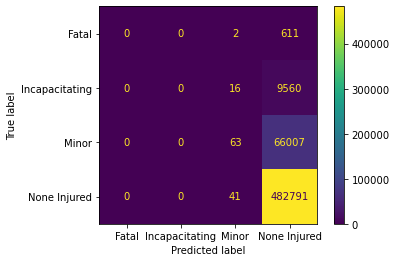

In [44]:
plot_confusion_matrix(log_model, X_train, y_train);

In [45]:
print("Training Score: ", log_model.score(X_train, y_train))
print("Testing Score: ", log_model.score(X_test, y_test))

Training Score:  0.8636411603835512
Testing Score:  0.8632192912794316


## SMOTE

In [ ]:
# Instantiate our SMOTE
sm = SMOTE(random_state=42)
# Fit and resample on the training data! X_tr_samp, y_tr_samp
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [ ]:
print("Training Score: ", log_model.score(X_train_smote, y_train_smote))
print("Testing Score: ", log_model.score(X_test, y_test))